In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
from proj1_helpers import *
testY,train=load_csv_data("../../dataset/test.csv", sub_sample=False)
train=load_csv_data("../../dataset/train.csv", sub_sample=False)

In [ ]:
# data clean plus normalization

In [26]:
initial_w=np.zeros((30,))
initial_w0=np.zeros((31,))
max_iters=500
#gamma=3e-7
#lambda_=10
#degree=4

In [58]:
train[1].shape

(250000, 30)

In [49]:
np.where(train[0]==-1)[0].shape[0]

164333

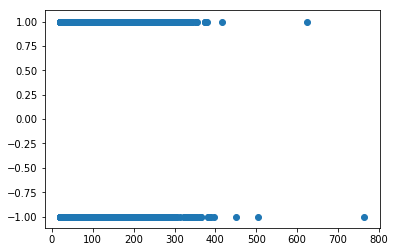

In [121]:
# 4,6,7,11,12,14,15,18,20,23,24,25,27,28 is useless?
plt.scatter(train[1][:,13],train[0][:])

In [137]:
smallTrain=np.concatenate([train[1][:,:4],train[1][:,5:6],train[1][:,8:11],train[1][:,13:14],train[1][:,16:18],train[1][:,21:23]],axis=1)

Need to make a train-test split of train data to cross-validate, with a symmetric number of y

In [149]:
np.random.seed(2)
from split_data import *
tr_trainX,tr_trainY,tr_testX,tr_testY=split_data(smallTrain,train[0],0.6)

In [5]:
def build_poly(tx,degree):
    poly = np.ones((len(tx), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(tx, deg)]
    return poly

In [138]:
degree=4
tx=build_poly(smallTrain,degree)

In [29]:
from costs import *
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    e=y-np.dot(tx,w)
    grad=-tx.T.dot(e)/y.shape[0]
    return grad

def least_squares_GD(y,tx,initial_w,max_iters,gamma):
    w = initial_w
    for n_iter in range(max_iters):
        grad=compute_gradient(y,tx,w)
        old_loss=compute_mse(y,tx,w)
        w=w-gamma*grad
        loss=compute_mse(y,tx,w)
        if (old_loss-loss)/old_loss<5e-5:
            break
    return w, loss

In [7]:
from helpers import batch_iter
def least_squares_SGD(y,tx,initial_w,max_iters,gamma):
    w = initial_w
    batch_size=50
    for n_iter in range(max_iters):
        for yBatch,txBatch in batch_iter(y, tx, batch_size):
            grad=compute_gradient(yBatch,txBatch,w)
            w=w-gamma*grad
            loss=compute_mse(y,tx,w)
    return w, loss

In [8]:
from costs import *
def least_squares(y,tx):
    if len(y)!=tx.shape[0]:
        raise ValueError("y and tx must have the same length")
    w = np.linalg.solve(np.dot(tx.transpose(), tx), np.dot(tx.transpose(), y))
    loss=compute_mse(y,tx,w)
    return w, loss

In [9]:
from costs import *
def ridge_regression(y,tx,lambda_):
    w=np.linalg.solve(tx.T.dot(tx)+2*tx.shape[0]*lambda_*np.eye(tx.shape[1]),tx.T.dot(y))
    loss=compute_mse(y,tx,w)
    return w, loss

In [ ]:
def logistic_regression(y,tx,initial_w,max_iters,gamma):
    return w, loss

In [ ]:
def reg_logistic_regression(y,tx,lambda_,initial_w,max_iters,gamma):
    return w, loss

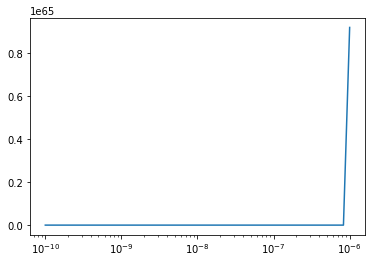

In [11]:
gammas=np.logspace(-10,-6,50)
losses=[]
for gamma in gammas:
    w,loss=least_squares_GD(train[0],train[1],initial_w,max_iters,gamma)
    losses.append(loss)
plt.semilogx(gammas,losses)

In [17]:
gamma=gammas[np.argmin(losses)]
print(gamma)

3.23745754282e-07


In [30]:
w,loss=least_squares_GD(train[0],train[1],initial_w,max_iters,gamma)
print(loss)

0.394599787444


In [139]:
w,loss=least_squares(train[0],tx)
print(loss)

0.318862396553


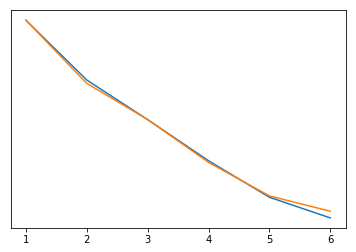

In [150]:
# higher degree give worst results
degrees=range(1,7)
losses=[]
losses_te=[]
for degree in degrees:
    tx=build_poly(tr_trainX,degree)
    tx_trtest=build_poly(tr_testX,degree)
    w,loss=least_squares(tr_trainY,tx)
    losses.append(loss)
    losses_te.append(compute_mse(tr_testY,tx_trtest,w))
plt.semilogy(degrees,losses)
plt.semilogy(degrees,losses_te)

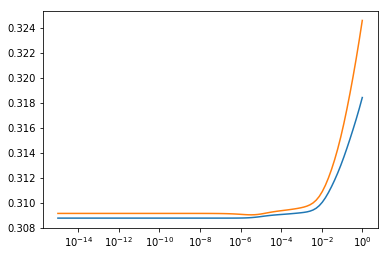

In [164]:
degree=5
tx=build_poly(tr_trainX,degree)
tx_trtest=build_poly(tr_testX,degree)
lambdas= np.logspace(-15, 0, 100)
losses=[]
losses_te=[]
ws=[]
for lambda_ in lambdas:
    w,loss=ridge_regression(tr_trainY,tx,lambda_)
    losses.append(loss)
    losses_te.append(compute_mse(tr_testY,tx_trtest,w))
    ws.append(w)
plt.semilogx(lambdas,losses)
plt.semilogx(lambdas,losses_te)
# pick lambda where losses_te is minimum
lambda_=lambdas[np.argmin(losses_te)]
w=ws[np.argmin(losses_te)]

In [157]:
degree=5
tx=build_poly(train[1],degree)
w,loss=ridge_regression(train[0],tx,lambda_)
print(loss)

0.301693697574


In [165]:
smallTest=np.concatenate([test[1][:,:4],test[1][:,5:6],test[1][:,8:11],test[1][:,13:14],test[1][:,16:18],test[1][:,21:23]],axis=1)
tx_test=build_poly(smallTest,degree)
ypred=predict_labels(w,tx_test)
create_csv_submission(test[2],ypred,"submission.csv")